In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh, CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch import optim

from torch.distributions.multivariate_normal import MultivariateNormal

from torchinfo import summary

from models import U_Net

from RectifiedFlow import RectifiedFlow_Unet, train_rectified_flow_Unet_reverse

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 256   #len: 5918
#num_samples_train = 10000

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data",
    download=True,
    train=True,
    transform=transform,
)

#train_dataset.data = train_dataset.data[np.isin(train_dataset.targets, [1,4])]
#train_dataset.targets = train_dataset.targets[np.isin(train_dataset.targets, [1,4])]

test_dataset = datasets.MNIST(
    "./data",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
input_shape = (batch_size, 2, 32, 32)

In [5]:
v_model_1 = U_Net(input_shape=input_shape, output_channels=1, initial_lr=5e-3, momentum=0.9, weight_decay=0.0)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [6]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)
# optim.beta1 = 0.9
# optim.eps = 1e-8
#optimizer_1 = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3, momentum=0.99)
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

In [7]:
rectified_flow_1 = train_rectified_flow_Unet_reverse(rectified_flow_1, optimizer_1, scheduler_1, train_dataloader, device, epochs=16)

Epoch 00315: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00516: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00674: reducing learning rate of group 0 to 2.5600e-03.
Epoch 00755: reducing learning rate of group 0 to 2.0480e-03.
Epoch 00862: reducing learning rate of group 0 to 1.6384e-03.
Epoch 00943: reducing learning rate of group 0 to 1.3107e-03.
Epoch 01031: reducing learning rate of group 0 to 1.0486e-03.
Epoch 01112: reducing learning rate of group 0 to 8.3886e-04.
Epoch 01193: reducing learning rate of group 0 to 6.7109e-04.
Epoch 01324: reducing learning rate of group 0 to 5.3687e-04.
Epoch 01405: reducing learning rate of group 0 to 4.2950e-04.
Epoch 01503: reducing learning rate of group 0 to 3.4360e-04.
Epoch 01584: reducing learning rate of group 0 to 2.7488e-04.
Epoch 01665: reducing learning rate of group 0 to 2.1990e-04.
Epoch 01746: reducing learning rate of group 0 to 1.7592e-04.
Epoch 01827: reducing learning rate of group 0 to 1.4074e-04.
Epoch 01

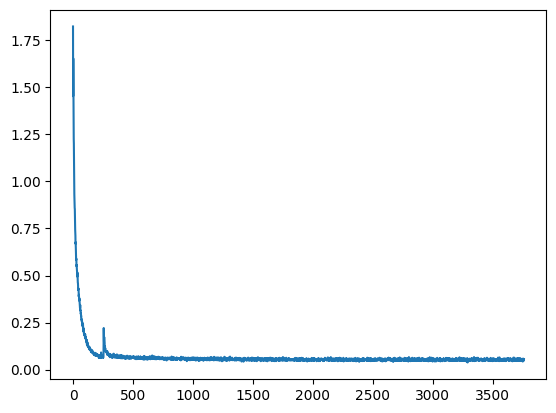

In [9]:
plt.plot(rectified_flow_1.loss_curve)
plt.show()

In [10]:
torch.save(rectified_flow_1, "./models/MNIST_All_Unet__reverse_flow1.pth")

In [16]:
rectified_flow_1 = torch.load("./models/MNIST_All_Unet__reverse_flow1.pth")

In [11]:
print(__file__)

NameError: name '__file__' is not defined

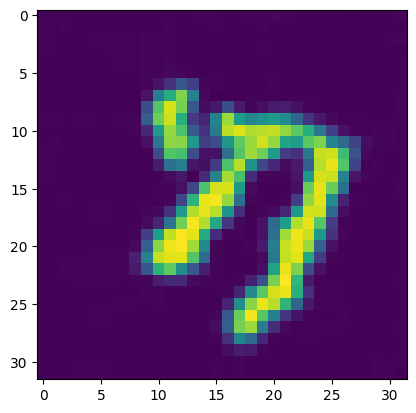

In [12]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device) * 1/3

img = rectified_flow_1.reverse_sample_ode(img_init, 100)

#print(img[-1])

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

[]

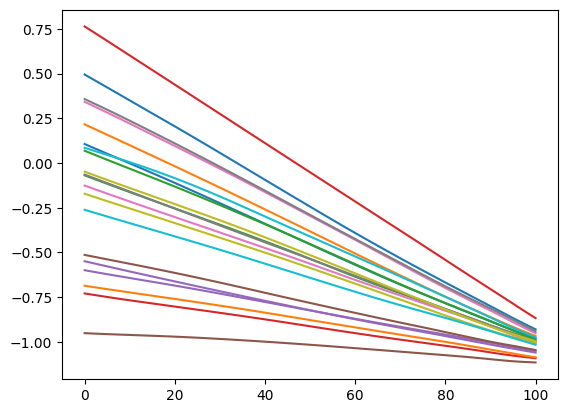

In [51]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,0,0].cpu().numpy())
plt.plot()

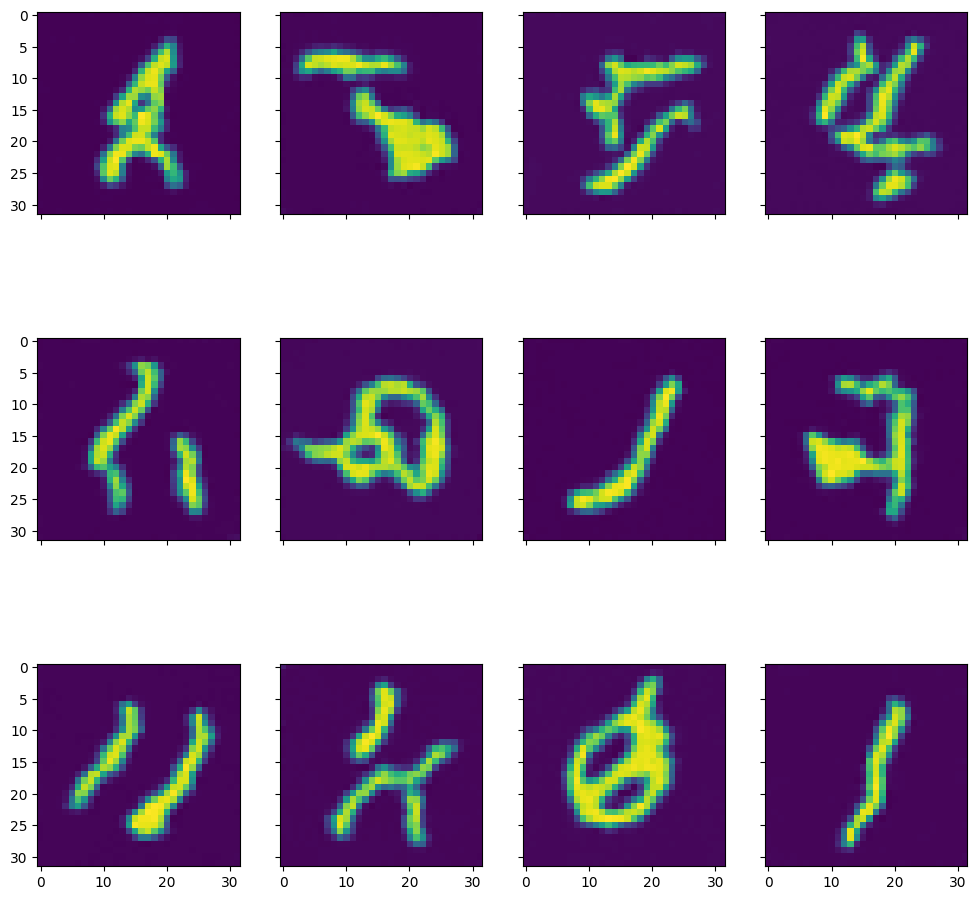

In [13]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,1,32,32).to(device) / 3

        img = rectified_flow_1.reverse_sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()

In [22]:
samples_init = torch.randn(2000,1,32,32).to(device) / 3 # do this sampeling in batches ?
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)

RuntimeError: CUDA out of memory. Tried to allocate 500.00 MiB (GPU 0; 7.79 GiB total capacity; 4.95 GiB already allocated; 84.75 MiB free; 6.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
v_model_2 = U_Net(input_shape=input_shape, output_channels=1, initial_lr=5e-3, momentum=0.9, weight_decay=0.0)
rectified_flow_2 = RectifiedFlow_Unet(v_model_2, device)

In [ ]:
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)
# optim.beta1 = 0.9
# optim.eps = 1e-8
#optimizer_1 = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3, momentum=0.99)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.8, patience=80, verbose=True)

In [ ]:
rectified_flow_2 = train_rectified_flow_Unet(rectified_flow_2, optimizer_2, scheduler_2, train_dataloader, device, epochs=60)

Epoch 00551: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00652: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00763: reducing learning rate of group 0 to 2.5600e-03.
Epoch 00880: reducing learning rate of group 0 to 2.0480e-03.
Epoch 00961: reducing learning rate of group 0 to 1.6384e-03.
Epoch 01042: reducing learning rate of group 0 to 1.3107e-03.
Epoch 01123: reducing learning rate of group 0 to 1.0486e-03.
Epoch 01278: reducing learning rate of group 0 to 8.3886e-04.
Epoch 01359: reducing learning rate of group 0 to 6.7109e-04.
Epoch 01440: reducing learning rate of group 0 to 5.3687e-04.
Epoch 01521: reducing learning rate of group 0 to 4.2950e-04.
Epoch 01602: reducing learning rate of group 0 to 3.4360e-04.
Epoch 01683: reducing learning rate of group 0 to 2.7488e-04.
Epoch 01764: reducing learning rate of group 0 to 2.1990e-04.
Epoch 01930: reducing learning rate of group 0 to 1.7592e-04.
Epoch 02011: reducing learning rate of group 0 to 1.4074e-04.
Epoch 02

In [ ]:
torch.save(rectified_flow_2, "./models/MNIST_newest_ref1.pth")

In [ ]:
rectified_flow_2 = torch.load("./models/MNIST_newest_ref1.pth")

tensor([[[[-0.9930, -1.0088, -1.0064,  ..., -1.0125, -1.0055, -0.9762],
          [-0.9936, -0.9874, -0.9879,  ..., -0.9942, -0.9839, -1.0150],
          [-0.9848, -0.9936, -0.9995,  ..., -0.9833, -1.0040, -0.9976],
          ...,
          [-0.9899, -1.0035, -1.0079,  ..., -1.0005, -0.9994, -0.9871],
          [-0.9933, -1.0009, -1.0023,  ..., -0.9963, -0.9966, -0.9948],
          [-0.9997, -1.0072, -1.0046,  ..., -0.9992, -0.9983, -0.9899]]],


        [[[-0.9801, -1.0077, -1.0098,  ..., -0.9986, -0.9884, -0.9866],
          [-0.9902, -0.9904, -1.0030,  ..., -1.0046, -0.9851, -0.9800],
          [-0.9845, -0.9931, -0.9984,  ..., -1.0118, -0.9973, -0.9819],
          ...,
          [-0.9918, -1.0022, -0.9894,  ..., -1.0016, -1.0048, -0.9975],
          [-0.9836, -0.9842, -0.9955,  ..., -1.0058, -1.0158, -0.9897],
          [-0.9819, -0.9891, -1.0031,  ..., -0.9978, -1.0025, -0.9883]]],


        [[[-0.9782, -1.0020, -0.9904,  ..., -1.0117, -0.9884, -0.9851],
          [-0.9910, -1.013

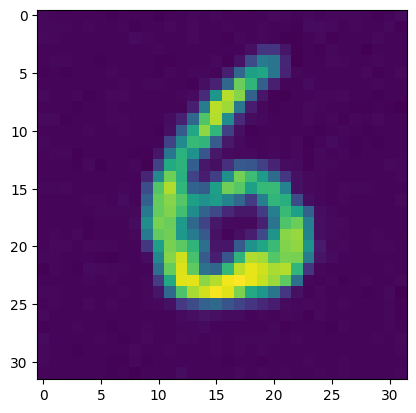

In [ ]:
rectified_flow_2.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device) / 3

img = rectified_flow_2.sample_ode(img_init, 3)

print(img[-1])

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

[]

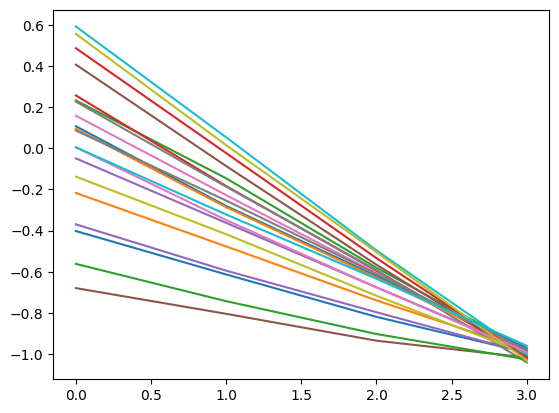

In [ ]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,0,0].cpu().numpy())
plt.plot()

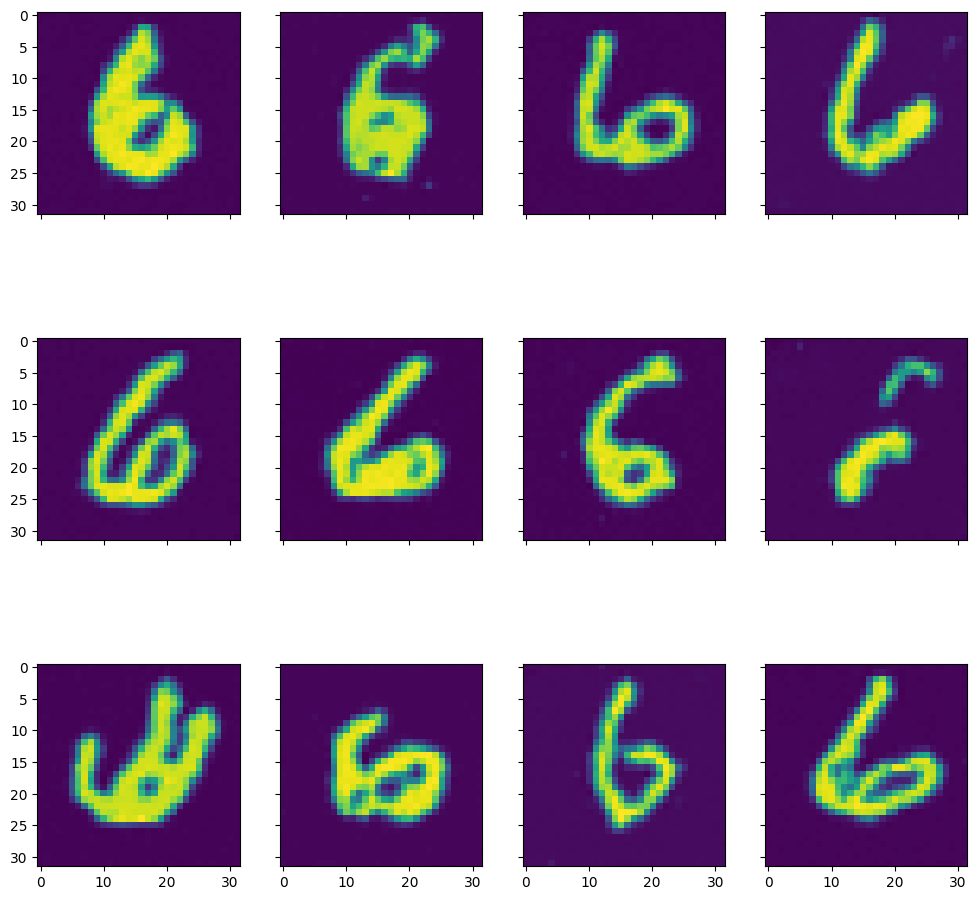

In [ ]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,1,32,32).to(device) / 3

        img = rectified_flow_2.sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()

In [ ]:
def show_trajectories(rectified_flow):
    rectified